# <center> Integer Programming </center> <br> <center> Stock Portfolio Optimization </center>

In [3]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

GUROBI_TIMER = 10

## Part 1: Stock selection

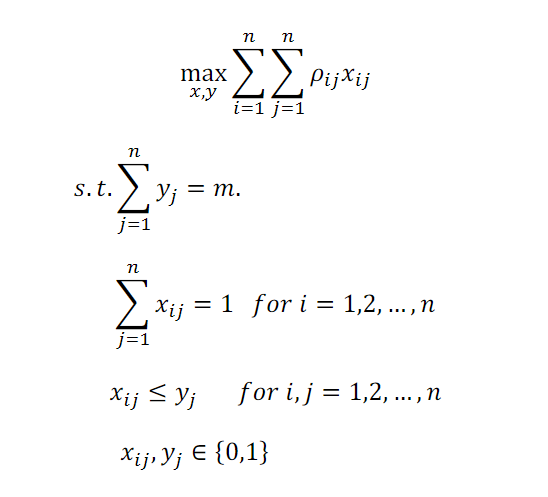

In [4]:
def fund_selection(stocks, m):
    '''
    Optmization function to select 'm' stocks from the dataset 'stocks' with 'n_stocks' stocks
    '''
    stocks = stocks.drop('NDX',axis=1)

    ## Calculating percentage change
    stocks = stocks.pct_change().dropna()

    ## Correlation Matrix
    corrM = stocks.corr()
    n_stocks = corrM.shape[0]
    
    ## Objective function
    obj = (corrM.to_numpy().flatten())
    obj = np.concatenate([obj,np.zeros(n_stocks)])
    n_variables = len(obj)

    X = pd.DataFrame(index=stocks.columns, columns = stocks.columns)
    X.fillna(0,inplace=True)
    
    A = np.zeros((1+n_stocks+(n_stocks**2),n_variables))

    ## First constraint
    A[0][-n_stocks:] = 1

    ## Second constraint
    for i in range(1, n_stocks+1):
        X1 = X.copy()
        X1.iloc[i-1] = 1
        A[i] = np.concatenate([X1.to_numpy().flatten(),np.zeros(n_stocks)])

    x = np.zeros(n_stocks)

    ## Third constraint
    for j in range(0, n_stocks):
        for k in range(0, n_stocks):    
            X1 = X.copy()
            X1.iloc[j,k] = 1

            x1 = x.copy()
            x1[k] = -1

            A[i+1] = np.concatenate([X1.to_numpy().flatten(),x1])
            i = i+1
    
    ## RHS values of the constraints
    b = [m] + [1]*n_stocks + [0]*(n_stocks**2)
    
    ## Sense matrix showing the relationship between LHS and RHS
    sense = ['='] + ['=']*n_stocks + ['<']*(n_stocks**2)    
    
    ipMod = gp.Model()
    ipMod_x = ipMod.addMVar(len(obj),vtype=['B']*len(obj)) # 'C' or 'I' or 'B'
    ipMod_con = ipMod.addMConstrs(A, ipMod_x, sense, b)
    ipMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

    ipMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    ipMod.optimize()
    
    return stocks, ipMod_x.x

### Running the model for 2019 data

In [3]:
## Read in the data file for 2019 stocks
stocks = pd.read_csv('stocks2019.csv')
stocks.X = pd.to_datetime(stocks.X)
stocks = stocks.set_index('X')

In [4]:
## Set m=5 to select top 5 stocks in the fund
m = 5

## Call the function to optimize the model for fund selection
stocks_result, obj_x = fund_selection(stocks, m)

Academic license - for non-commercial use only - expires 2022-08-27
Using license file C:\Users\ssahi\gurobi.lic


### Identifying the stocks in the fund as per the above constraints

In [5]:
result = stocks_result.columns[obj_x[-stocks_result.shape[1]:]==1]
result

Index(['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL'], dtype='object')

## Part 2: Calculating portfolio stock weights

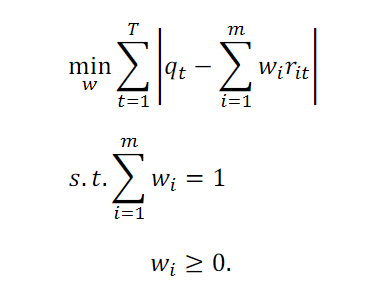

In [6]:
def weight_calc(stocks, m, result):

    '''Given 'm' selected stocks for the fund, calculate the weights for each stock in the fund ''' 
    
    ## Calculating percentage change
    stocks = stocks.pct_change().dropna()
    
    A = np.zeros(((2*stocks.shape[0])+1,stocks.shape[0]+m))

    q = []
    n = stocks.shape[0]
    
    ## First constraint  
    for i in range(n):
        q.append(stocks.iloc[i]['NDX'])
        A[i][i] = 1
        A[i+n][i] = 1
        A[i][-m:] = stocks.iloc[i][result.values]
        A[i+n][-m:] = -stocks.iloc[i][result.values]
    
    ## Second constraint
    A[-1][-m:] = 1 
    
    ## RHS values for constraints
    q_1 = [-1*x for x in q]
    b = q + q_1 + [1]

    ## Objective for the LP
    obj = [1]*(stocks.shape[0])+[0]*m
    obj = np.array(obj)

    b = np.array(b)
    
    ## Sense matrix showing the relationship between LHS and RHS
    sense = ['>']*(2*n) + ['=']
    
    sense = np.array(sense)
    
    ipMod = gp.Model()
    ipMod_x = ipMod.addMVar(len(obj)) # 'C' or 'I' or 'B'
    ipMod_con = ipMod.addMConstrs(A, ipMod_x, sense, b)
    ipMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    ipMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    ipMod.optimize()
    
    return pd.DataFrame(ipMod_x.x[-m:],index=result,columns=['Weights']), ipMod.objVal

### Calculate portfolio weights for m=5 stocks in the fund

In [7]:
weights,obj_val = weight_calc(stocks, m, result)

weights = pd.DataFrame(weights[-m:],index=result,columns=['Weights'])
weights

,Weights
LBTYK,0.048862
MXIM,0.210388
MSFT,0.580352
VRTX,0.071190
XEL,0.089208


### Tracking the portfolio for 2020 data and calculating tracking error

In [8]:
## Read in the 2020 stocks for calculating tracking error for 2020 stocks dataset

stocks_2020 = pd.read_csv('stocks2020.csv')
stocks_2020['Unnamed: 0'] = pd.to_datetime(stocks_2020['Unnamed: 0'])
stocks_2020 = stocks_2020.set_index('Unnamed: 0')
stocks_2020.head()

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2020-01-02,8872.219727,58.266792,334.429993,49.099998,107.839996,283.679993,1368.680054,1367.369995,1898.010010,231.917572,...,36.970001,254.550003,196.729996,150.167465,219.449997,56.046688,167.460007,64.771545,60.782249,100.115349
2020-01-03,8793.900391,58.286655,331.809998,48.599998,106.410004,280.440002,1361.520020,1360.660034,1874.969971,230.343124,...,36.180000,250.169998,200.880005,151.628220,217.979996,56.046688,168.440002,63.774597,61.074562,97.810677
2020-01-06,8848.519531,59.349670,333.709991,48.389999,106.580002,285.880005,1397.810059,1394.209961,1902.880005,232.110748,...,35.689999,250.949997,202.740005,151.976013,224.029999,56.530506,169.490005,62.550629,60.986866,95.771927
2020-01-07,8846.450195,59.945747,333.390015,48.250000,106.849998,283.059998,1395.109985,1393.339966,1906.859985,229.927765,...,37.330002,253.089996,203.210007,153.247955,223.789993,56.245903,172.949997,66.785164,60.860199,97.958405
2020-01-08,8912.370117,59.488754,337.869995,47.830002,108.580002,286.000000,1405.040039,1404.319946,1891.969971,230.101654,...,36.869999,258.000000,204.149994,154.658997,231.089996,52.963551,178.710007,67.752487,60.801735,97.682640


In [43]:
def portfolio_error(stocks, weights):
    ''' Given a stocks dataset and selected fund weights, compare the index(NDX) with the fund to calculate tracking error'''
    tickers = weights.index.to_list()
    
    returns = stocks[['NDX']+tickers].pct_change().dropna()
    returns['fund'] = returns[tickers]@weights

    returns['diff'] = abs(returns['NDX'] - returns['fund'])
    
    return returns

    
def portfolio_track(stocks, weights, year):
    ''' Given a stocks dataset and selected fund weight, create a graph to show how the fund tracks the index(NDX)'''
    tickers = weights.index.to_list()
    stocks_copy = stocks[['NDX']+tickers]

    stocks_copy['fund'] = stocks_copy[tickers]@weights

    scale = stocks_copy['NDX'][0]/stocks_copy['fund'][0]
    stocks_copy['fund'] = stocks_copy['fund'] * scale
    
    
    plt.style.use('ggplot')
    stocks_copy[['NDX','fund']].plot(kind='line', figsize=(20,10))
    plt.legend(prop={'size': 18})

    
    plt.title(f'Tracking NDX with m={m} stocks for year {year}')
    plt.xlabel('Date', fontsize=18)
    

Tracking error for 2020:  0.3686708536103141
Tracking error for 2019:  0.04491115168422106


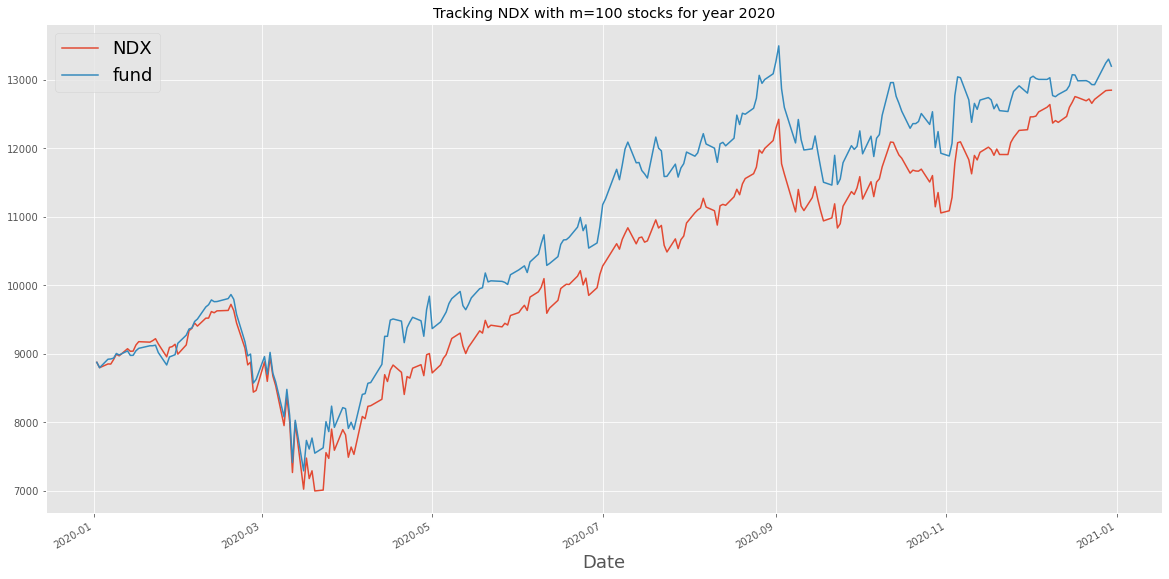

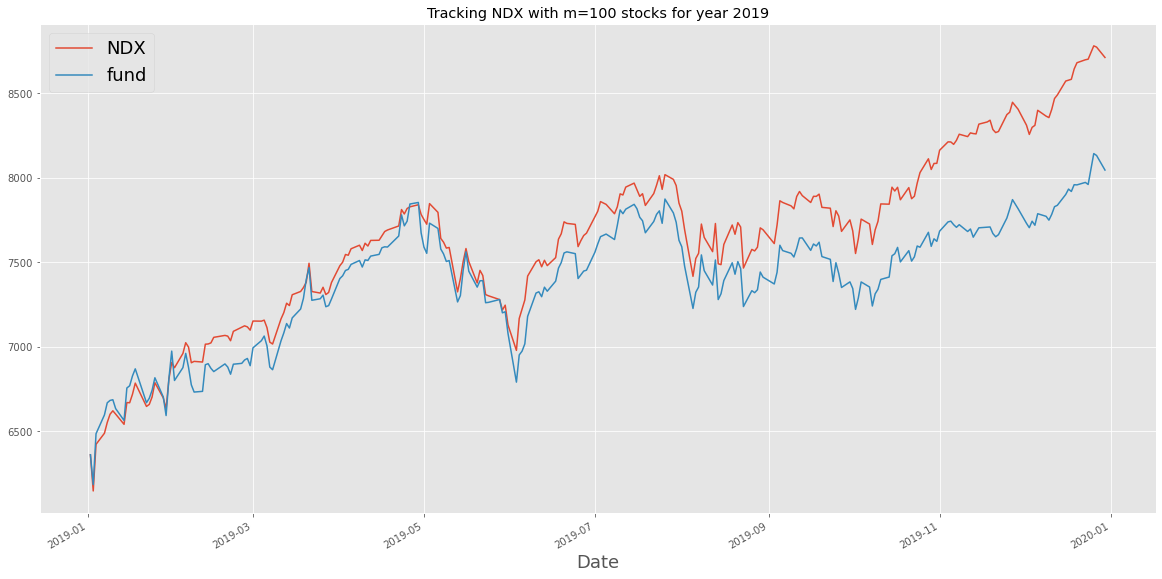

In [44]:
## Calculate tracking error for 2020 dataset using 'm' stock weights in the fund
track_err = portfolio_error(stocks_2020, weights)
portfolio_track(stocks_2020, weights, 2020)
print('Tracking error for 2020: ',track_err['diff'].sum())

## Calculate tracking error for 2019 dataset using 'm' stock weights in the fund
track_err = portfolio_error(stocks, weights)
portfolio_track(stocks, weights, 2019)
print('Tracking error for 2019: ',track_err['diff'].sum())


### Testing with other values of 'm' and tracking the error

In [11]:
err_2020 = pd.Series([],dtype=float)
err_2019 = pd.Series([],dtype=float)

for m in range(10,stocks.columns.shape[0],10):    
    stocks_result, obj_x = fund_selection(stocks, m)
    result = stocks_result.columns[obj_x[-stocks_result.shape[1]:]==1]

    weights,obj_val = weight_calc(stocks, m, result)

    err_2020[m] = portfolio_error(stocks_2020, weights)['diff'].sum()
    err_2019[m] = portfolio_error(stocks, weights)['diff'].sum()

In [12]:
err_2019

10     0.686533
20     0.473736
30     0.418015
40     0.367439
50     0.334010
60     0.343788
70     0.168587
80     0.147683
90     0.053779
100    0.044911
dtype: float64

In [13]:
err_2020

10     1.097709
20     0.940289
30     0.769110
40     0.788335
50     0.773216
60     1.166438
70     0.545744
80     0.537323
90     0.367790
100    0.368671
dtype: float64

In [45]:
def portfolio_err_track(err_2019, err_2020):
    errors = pd.concat([err_2019,err_2020], axis=1)
    errors.columns = ['2019','2020']
    plt.style.use('ggplot')
    errors.plot(kind='line', figsize=(20,10))
    plt.legend(prop={'size': 18})
    plt.title(f'Tracking errors for 2019 and 2020')
    plt.xlabel('Number of stocks selected in the fund', fontsize=18)

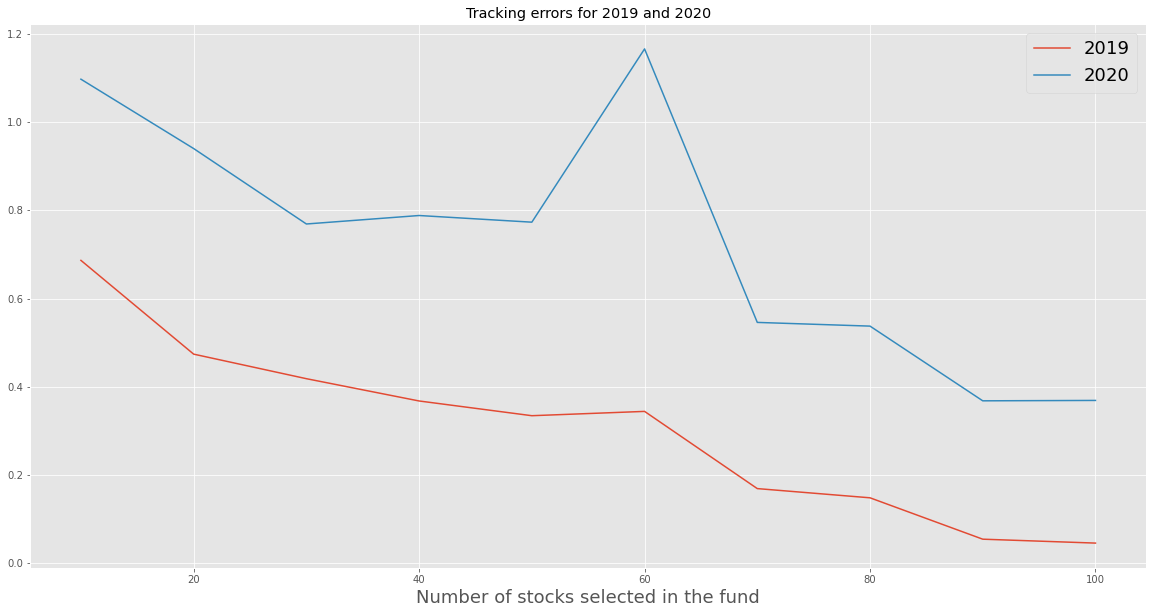

In [46]:
portfolio_err_track(err_2019, err_2020)



### Running a combined linear programming function for stocks selection & weight calculation

In [16]:
def combined_fund(stocks, m):
    
    ''' Given stocks dataset and a value 'm', identify 'm' stocks and their weights for the portfolio'''
    
    stocks = stocks.pct_change().dropna()
    
    ndx = stocks['NDX']
    q = ndx.to_list() + (-ndx).to_list()
    
    stocks = stocks.drop('NDX', axis=1)

    days = stocks.shape[0]
    no_stocks = stocks.shape[1]
    
    A = np.zeros(((2*days)+2+(no_stocks-1)+1,days+(2*no_stocks-1)+1))

    ## Constraint
    for i in range(days):
        A[i][i] = 1
        A[i+days][i] = 1
        A[i][-(2*no_stocks):-no_stocks] = stocks.iloc[i]
        A[i+days][-(2*no_stocks):-no_stocks] = -stocks.iloc[i]
        
    for i in range(no_stocks):
        j = (2*days) + i
        A[j][days+i] = 1
        A[j][i - no_stocks] = -1
    
    A[-2][days:days+no_stocks] = 1
    A[-1][days+no_stocks:days+(2*no_stocks)] = 1
    
    ## RHS values for the constraints
    b = q + [0]*no_stocks + [1] + [m]
    
    ## Objective function
    obj = [1]*(stocks.shape[0])+[0]*2*no_stocks
    obj = np.array(obj)
    
    ## Sense matrix showing the relationship between LHS and RHS
    sense = ['>']*(2*days) + ['<']*no_stocks + ['=']*2

    sense = np.array(sense)
    
    ipMod = gp.Model()
    ipMod_x = ipMod.addMVar(len(obj),vtype=['C']*(days+no_stocks)+['B']*(no_stocks)) # 'C' or 'I' or 'B'
    ipMod_con = ipMod.addMConstrs(A, ipMod_x, sense, b)
    ipMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    ipMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    ipMod.Params.TimeLimit = GUROBI_TIMER
    ipMod.optimize()

    selected = pd.DataFrame(ipMod_x.x[-2*no_stocks:].reshape((2, no_stocks)), columns=[stocks.columns], index=['Weights','Selected stocks'])
    mask = selected.iloc[1,:]==1
    selected = selected.loc[:,mask].drop(['Selected stocks'])

    return selected.T.reset_index().set_index('level_0')


### Run the Combined LP problem for different values of m

In [18]:
err_2020_comb = pd.Series([],dtype=float)
err_2019_comb = pd.Series([],dtype=float)

for m in range(10,stocks.columns.shape[0],10):    
    selected = combined_fund(stocks, m)
    
    err_2019_comb[m] = portfolio_error(stocks, selected)['diff'].sum()
    err_2020_comb[m] = portfolio_error(stocks_2020, selected)['diff'].sum()

In [22]:
final = pd.DataFrame()
final["2019 Error"] = err_2019
final["2020 Error"] = err_2020
final["2019 Error (Combined LP)"] = err_2019_comb
final["2020 Error (Combined LP)"] = err_2020_comb
final.to_csv("mimicking_error.csv")
final

,2019 Error,2020 Error,2019 Error (Combined LP),2020 Error (Combined LP)
10,0.686533,1.097709,0.303570,0.691485
20,0.473736,0.940289,0.168084,0.503689
30,0.418015,0.769110,0.110810,0.479284
40,0.367439,0.788335,0.082621,0.407486
50,0.334010,0.773216,0.064602,0.371816
60,0.343788,1.166438,0.052619,0.388622
70,0.168587,0.545744,0.047899,0.367202
80,0.147683,0.537323,0.045227,0.370629
90,0.053779,0.367790,0.044911,0.368671
100,0.044911,0.368671,0.044911,0.368671


In [47]:
def portfolio_err_track(errors):
    plt.style.use('ggplot')
    errors.plot(kind='line', figsize=(20,10))
    plt.legend(prop={'size': 18})
    plt.title(f'Tracking errors for 2019 and 2020 using both methods')
    plt.xlabel('Number of stocks selected in the fund', fontsize=18)

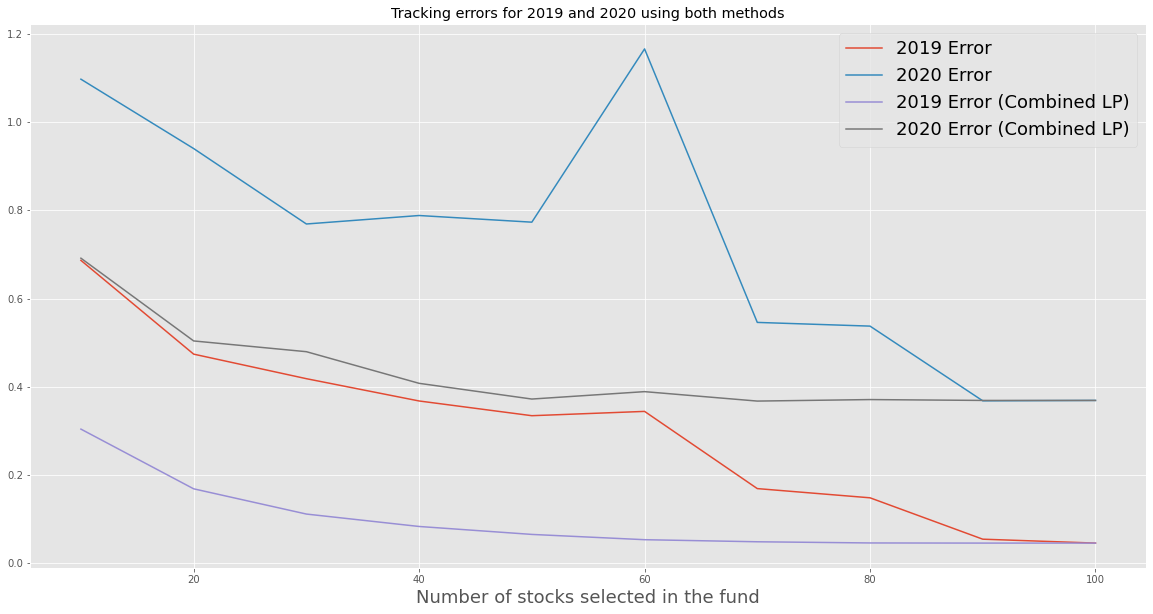

In [48]:
portfolio_err_track(final)

## END OF CODE